## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is provided below:

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

note: this step is only necessary if you are running in Colab. If you are running locally and have followed the python environment set-up steps in the README, these are already installed and available in your environment.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 34.6 MB/s eta 0:00:00


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 1.2 Imports

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import time
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from transformers import (MaskFormerForInstanceSegmentation, MaskFormerImageProcessor)

# custom imports
import utils.data_handler as dh
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.maskformer_train as mft

from utils.data_handler import DataHandler, MriType, LatentVector, StructuralScan
from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation, calc_slice_metrics, calc_subject_metrics
from utils.maskformer_inference import MaskFormerInference, get_mask_from_segm_result
from utils.maskformer_train import MaskFormerTrain
from utils.mri_common import SliceDirection
from utils.mri_plotter import MRIPlotter

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

data_handler = DataHandler()
mri_plt = MRIPlotter()

## 2. Download and Visualize the Dataset

Visualize raw data currently stored in OneDrive

### 2.0 Copy sample dataset into Google Colab runtime environment

The default directory for our data helper class is set to /data within the Colab runtime environment. For this demo, we will transfer a sample dataset into that directory.

In [ ]:
demo_dir = "./data/demo/00_upenn_gbm_data_raw/"
colab_data_dir = data_handler.data_dir + "/"
print("colab runtime directory", colab_data_dir)
print("demo source directory", demo_dir)

colab runtime directory /content/data/
demo source directory ./data/demo/00_upenn_gbm_data_raw/


In [ ]:
# run function to copy the files over
shutil.copytree(demo_dir, colab_data_dir, dirs_exist_ok=True)

'/content/data/'

Note: To use a different base directory, update the DATA_DIR folder stored in the utils.data_handler accordingly. After which, the data helper class will assume a fixed structure for different file types as you will see through the demo.

### 2.1 The dataset consists of the pre-operative MRI scans and their corresponding manually annotated images

In [ ]:
# Get a list of the pre-operative scans
struct_files, struct_dir = data_handler.list_mri_in_dir(mri_type=MriType.STRUCT_SCAN, return_dir=True)
print("List down the first five structural images")
struct_files[:5]

mri directory /content/data/images_structural
List down the first five structural images


['UPENN-GBM-00002_11_FLAIR.nii.gz',
 'UPENN-GBM-00002_11_T1.nii.gz',
 'UPENN-GBM-00002_11_T1GD.nii.gz',
 'UPENN-GBM-00002_11_T2.nii.gz',
 'UPENN-GBM-00006_11_FLAIR.nii.gz']

In [ ]:
# List down segmented images
segm_files, segm_dir = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED, return_dir=True)
print("List down the annotated images")
segm_files

mri directory /content/data/images_segm
List down the annotated images


['UPENN-GBM-00002_11_segm.nii.gz',
 'UPENN-GBM-00006_11_segm.nii.gz',
 'UPENN-GBM-00008_11_segm.nii.gz',
 'UPENN-GBM-00009_11_segm.nii.gz',
 'UPENN-GBM-00011_11_segm.nii.gz',
 'UPENN-GBM-00075_11_segm.nii.gz',
 'UPENN-GBM-00093_11_segm.nii.gz']

### 2.2 Visualize a segmented image

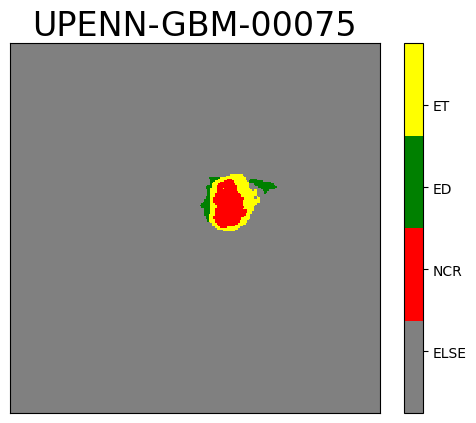

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1)
test_subj_id = "UPENN-GBM-00075"

# load the annotated image and get the slice with the largest tumor. this assumes depth slice
annotated_img = data_handler.load_mri(subj_id=test_subj_id, mri_type=MriType.ANNOTATED)
slice_idx = mri_common.get_largest_tumor_slice_idx(annotated_img)[0]

# plot the image on the calculated slice
mri_plt.plot_segm_img(img_data=annotated_img[:, :, slice_idx], fig=fig, axs=axs, row=0, col=1, title=f"{test_subj_id}")
plt.show()

### 2.3 Visualize the corresponding pre-operative scans

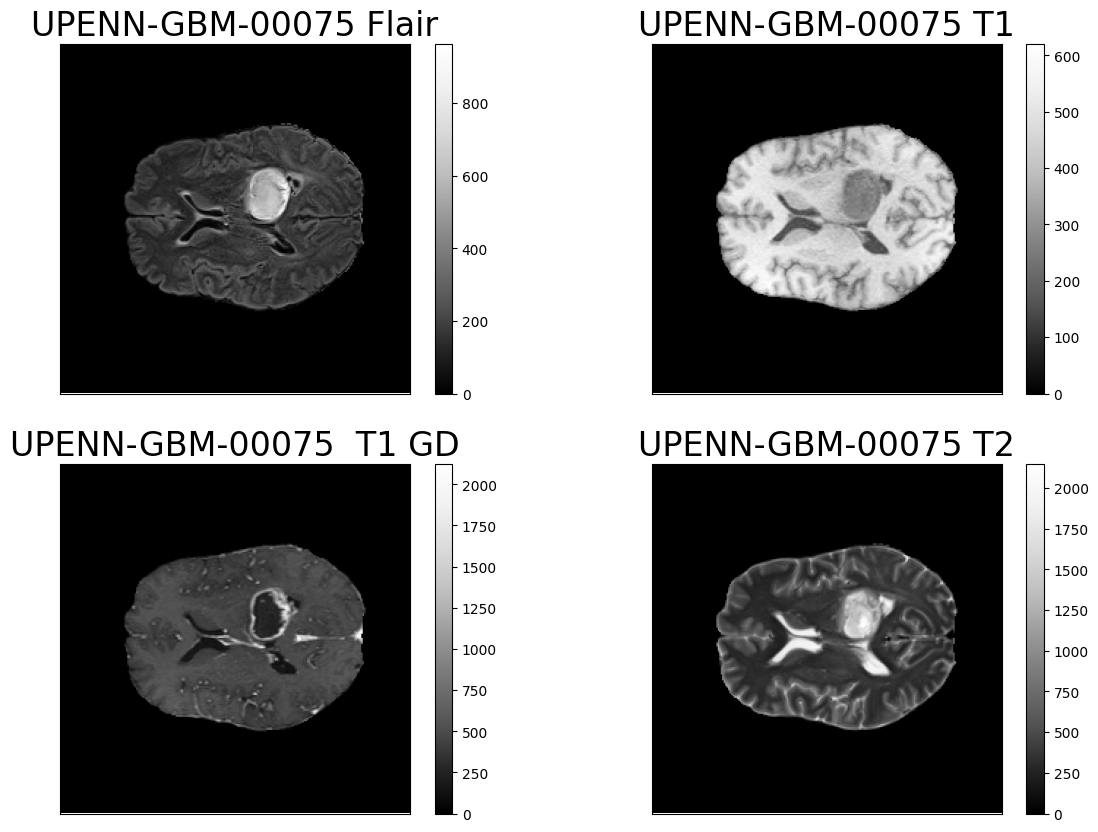

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# load and plot flair image
flair_img = data_handler.load_mri(subj_id=test_subj_id, mri_type=MriType.STRUCT_SCAN, struct_scan=StructuralScan.FLAIR)
mri_plt.plot_struct_img(img_data=flair_img[:, :, slice_idx], fig=fig, axs=axs, row=0, col=0, title=f"{test_subj_id} Flair")

# load and plot T1 image
t1_img = data_handler.load_mri(subj_id=test_subj_id, mri_type=MriType.STRUCT_SCAN,struct_scan=StructuralScan.T1)
mri_plt.plot_struct_img(img_data=t1_img[:, :, slice_idx], fig=fig, axs=axs, row=0, col=1, title=f"{test_subj_id} T1")

# load and plot T1 GD image
t1gd_img = data_handler.load_mri(subj_id=test_subj_id, mri_type=MriType.STRUCT_SCAN, struct_scan=StructuralScan.T1GD)
mri_plt.plot_struct_img(img_data=t1gd_img[:, :, slice_idx], fig=fig, axs=axs, row=1, col=0, title=f"{test_subj_id}  T1 GD")

# load and plot T2 image
t2_img = data_handler.load_mri(subj_id=test_subj_id, mri_type=MriType.STRUCT_SCAN, struct_scan=StructuralScan.T2)
mri_plt.plot_struct_img(img_data=t2_img[:, :, slice_idx], fig=fig, axs=axs, row=1, col=1, title=f"{test_subj_id} T2")

plt.show()

## 3. Apply pre-preprocessing methods

### 3.1 Zero-data removal

We look for zero-pixels at the edges across all images and determine the outer dimensions that can be trimmed.

Prepare input required for the zero-data removal function

In [ ]:
# Recall the directory of the structural scans retrieved from section 2.1
struct_dir

'/content/data/images_structural'

In [ ]:
# Convert enum structural scan types to a list.
# These are the list of scans that will be included in the zero-pixel evaluation.
# By default, we want to include all
struct_scans = [scan.value for scan in StructuralScan]
print("scan types:", struct_scans)

scan types: ['FLAIR', 'T1', 'T1GD', 'T2']


In [ ]:
# Save a list of the subjects from the manually annotated images.
# Note that the full dataset of structural scans contain images without manual annotations.
# preparing this list would make sure that we have corresponding segmentation for each scan
subjects = list(set([mri_common.get_mri_subj(filename) for filename in segm_files]))
subjects.sort()
subjects

['UPENN-GBM-00002',
 'UPENN-GBM-00006',
 'UPENN-GBM-00008',
 'UPENN-GBM-00009',
 'UPENN-GBM-00011',
 'UPENN-GBM-00075',
 'UPENN-GBM-00093']

Use the get_zero_reduction_dimensions function to identify edges that contain the zero-pixels across all images and determine how much of the edges can be trimmed.

In [ ]:
# pass the directory of the structural scans: struct_dir
# the list of annotated subjects
# and the list of struct scans to fetch: ['FLAIR', 'T1', 'T1GD', 'T2']
new_dim = mri_common.get_zero_reduction_dimensions(mri_dir=struct_dir, subj_list=subjects, struct_scan_list=struct_scans)

min idx in height is: 49 max idx in height is: 188
min idx in width is : 32 max idx in width is : 221
min idx in depth is : 0 max idx in depth is : 140
Original height / width / depth : 240 / 240 / 155
     New height / width / depth : 140 / 190 / 141
Data reduction : 57.99 %


Save all reduced data into a folder called "images_annot_reduced". Note that the name of the folder should not be changed.

In [ ]:
reduced_dir = os.path.join(data_handler.data_dir, 'images_annot_reduced')
mri_common.reduce_data(new_dim=new_dim,
                       subj_list=subjects,
                        struct_scans=struct_scans,
                        struct_scan_dir=struct_dir,
                        segm_dir=segm_dir,
                        output_dir=reduced_dir)

Dimension of Image are height: 139 width: 189 depth: 140


QC the new images created and compare them with the original images

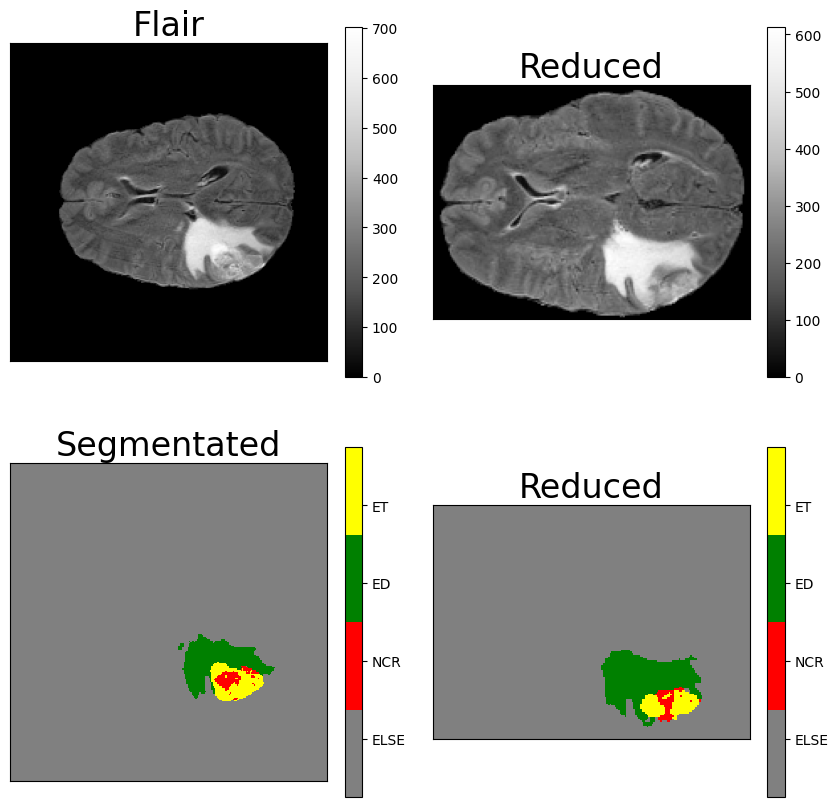

In [ ]:
# qc sample images
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
test_img = "UPENN-GBM-00011"

# Row 1: Flair
flair_img_raw = data_handler.load_mri(subj_id=test_img, mri_type=MriType.STRUCT_SCAN, struct_scan=StructuralScan.FLAIR)
flair_img_reduced = data_handler.load_mri(subj_id=test_img, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)

mri_plt.plot_struct_img(img_data=flair_img_raw, fig=fig, axs=axs, row=0, col=0, title=f"Flair")
mri_plt.plot_struct_img(img_data=flair_img_reduced, fig=fig, axs=axs, row=0, col=1, title=f"Reduced")

# Row 2: Segmented Image
annot_img_raw = data_handler.load_mri(subj_id=test_img, mri_type=MriType.ANNOTATED)
annot_img_reduced = data_handler.load_mri(subj_id=test_img, mri_type=MriType.ANNOTATED_REDUCED)

mri_plt.plot_segm_img(img_data=annot_img_raw, fig=fig, axs=axs, row=1, col=0, title=f"Segmentated")
mri_plt.plot_segm_img(img_data=annot_img_reduced, fig=fig, axs=axs, row=1, col=1, title=f"Reduced")

plt.show()

Inspect the shape of the reduced images

In [ ]:
REDUCED_HEIGHT, REDUCED_WIDTH, REDUCED_DEPTH = flair_img_reduced.shape
REDUCED_HEIGHT, REDUCED_WIDTH, REDUCED_DEPTH

(139, 189, 140)

### 3.2 Split subjects into Train, Val, Test

In [ ]:
train_list, reserve_list = mri_common.split_subjects(subjects, split_ratio=0.6, seed=2023)
val_list, test_list = mri_common.split_subjects(reserve_list, split_ratio=0.5, seed=2023)

print("Train", train_list)
print("Val", val_list)
print("Test", test_list)

Train ['UPENN-GBM-00009', 'UPENN-GBM-00075', 'UPENN-GBM-00093', 'UPENN-GBM-00011']
Val ['UPENN-GBM-00006', 'UPENN-GBM-00008']
Test ['UPENN-GBM-00002']


### 3.3 Normalize and save 3d cubes into Train, Val, and Test

Keep the name of the folder 'images_annot_reduced_norm' fixed

In [ ]:
normalized_dir = os.path.join(data_handler.data_dir, "images_annot_reduced_norm")

# normalized the reduced images and saved to the normalized_dir dir
mri_common.normalize_and_save(
    subjects_list=subjects,
    struct_scan_list=struct_scans,
    data_dir=reduced_dir,
    output_dir=normalized_dir,
    train_list=train_list,
    val_list=val_list,
    test_list=test_list
)

# copy the associated SEGM annotation masks into the normalized_dir
mri_common.copy_segm_files(
    norm_dir=normalized_dir,
    segm_dir=reduced_dir,
    subjects_list=subjects,
    train_list=train_list,
    val_list=val_list,
    test_list=test_list
)

Working on subject no: 1 / 7
Working on subject no: 2 / 7
Working on subject no: 3 / 7
Working on subject no: 4 / 7
Working on subject no: 5 / 7
Working on subject no: 6 / 7
Working on subject no: 7 / 7


After running everything above, the expected folder structure within the data directory should be as follows:

    - data
        - images_annot_reduced
        - images_annot_reduced_norm
            - test
            - train
            - val
        - images_segm
        - images_structural

## 4. Train the data

### 4.1 Generate 2d slices from the normalized files

In [ ]:
# Verify normalized_dir
normalized_dir

'/content/data/images_annot_reduced_norm'

In [ ]:
# Note that directory can also be retrieved by calling list_mri_in_dir and supplying the require MriType
norm_files, normalized_dir = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED_REDUCED_NORM, return_dir=True)
normalized_dir

mri directory /content/data/images_annot_reduced_norm


'/content/data/images_annot_reduced_norm'

Specify an orientation to cut the slices into. The function generate_2d_slices will create 2d slices based on the orientation supplied and will be saved to the supplied output dir.

In [ ]:
ORIENTATION = SliceDirection.DEPTH

data_dir = data_handler.data_dir
norm_2d_dir = os.path.join(data_dir, "images_annot_reduced_norm_2d")
data_dir_train, data_dir_val, data_dir_test = mri_common.generate_2d_slices(
    input_dir=normalized_dir,
    output_dir=norm_2d_dir,
    orientation=ORIENTATION
)

loaded_3d_mri_dir_train /content/data/images_annot_reduced_norm/train
loaded_3d_mri_dir_val /content/data/images_annot_reduced_norm/val
loaded_3d_mri_dir_test /content/data/images_annot_reduced_norm/test
Extracting 2D slices from 3D volumes (now is a good time to take 5 min coffee break ...)


  0%|          | 0/3 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/train --> /content/data/images_annot_reduced_norm_2d/train/depth


  0%|          | 0/20 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/val --> /content/data/images_annot_reduced_norm_2d/val/depth


  0%|          | 0/10 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/test --> /content/data/images_annot_reduced_norm_2d/test/depth


  0%|          | 0/5 [00:00<?, ?it/s]

Obtain the files from each directory and select a subset for training. For now, we supply a large arbitrary number for file_no_max. This corresponds to the a slice in the 3d volume and specifying a large number such as 500 will simply include all slices in the training.

In [ ]:
train_2d = data_handler.list_mri_in_dir(local_path=data_dir_train)
val_2d = data_handler.list_mri_in_dir(local_path=data_dir_val)
test_2d = data_handler.list_mri_in_dir(local_path=data_dir_test)

train_data_list = mf_utils.get_subset_files(train_2d, file_no_min=0, file_no_max=500, subj_id_min=0, subj_id_max=500)
val_data_list = mf_utils.get_subset_files(val_2d, file_no_min=0, file_no_max=500, subj_id_min=0, subj_id_max=500)
test_data_list = mf_utils.get_subset_files(test_2d, file_no_min=0, file_no_max=500, subj_id_min=0, subj_id_max=500)

mri directory /content/data/images_annot_reduced_norm_2d/train/depth
mri directory /content/data/images_annot_reduced_norm_2d/val/depth
mri directory /content/data/images_annot_reduced_norm_2d/test/depth


The function will generate a list with the below file naming convention and will serve as the input list to the MaskFormer dataloader. This format will indicate the subject and slice (file_no) to load.

In [ ]:
train_data_list[0:5]

['UPENN-GBM-00009_0.nii.gz',
 'UPENN-GBM-00009_1.nii.gz',
 'UPENN-GBM-00009_2.nii.gz',
 'UPENN-GBM-00009_3.nii.gz',
 'UPENN-GBM-00009_4.nii.gz']

### 4.2 Initialize parameters for training

In [ ]:
# the identifier for the run. this is simply appended to any file save during the run
TRAIN_ID = "demo"

# By default, all models are saved to the cloud in
# This indicates the subfolder within rice_d2k_biocv/training where you want the models stored.
TRAIN_DIR_PREFIX = "maskformer/demo"
BATCH_SIZE = 2
N_EPOCH = 5

# Setting default Maskformer dimensions to train our data
WIDTH, HEIGHT = 512, 512

In [ ]:
# Get the first file name from the train_data_list to get original dimension.
# We will need this when we scale our prediction back to the original dimension.
ORIG_DIMENSIONS = data_handler.load_mri(subj_id=mri_common.get_mri_subj(train_data_list[0]),
                                 local_path=data_dir_train,
                                 file_no=mri_common.get_mri_file_no(train_data_list[0])).shape
ORIG_DIMENSIONS

(139, 189)

### 4.3 Initialize model variables

In [ ]:
# Initalize MaskFormer processor
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

# Define default data transforms
train_transform = A.Compose([
    A.Resize(width=WIDTH, height=HEIGHT),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

Initalize the dataloaders for the training and validation datasets. Set augmentation to True for the training dataset

In [ ]:
# create The training and validation dataset
train_dataset = MaskformerMRIDataset(
    data_dir=data_dir_train,
    data_list=train_data_list,
    processor=processor,
    transform=train_transform,
    augment=True
)
val_dataset = MaskformerMRIDataset(
    data_dir=data_dir_val,
    data_list=val_data_list,
    processor=processor,
    transform=train_transform,
    augment=False
)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### 4.4 Fine-tune the Model

Define the model

In [ ]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the label dictionary required by the maskformer model
id2label, label2id = mf_utils.get_label_dictionary(mri_common.SEGMENTS)
print(id2label)
print(label2id)

# Load pre-trained maskformer model
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-small-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-small-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.5 Train the model

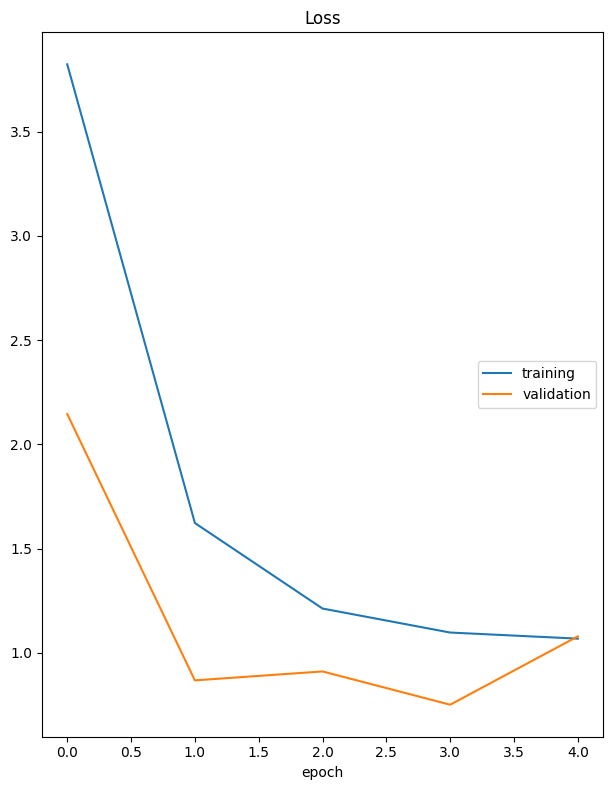

Loss
	training         	 (min:    1.068, max:    3.822, cur:    1.068)
	validation       	 (min:    0.751, max:    2.145, cur:    1.079)


In [ ]:
# intialize MaskFormerTrain to call train supplying the parameters initialized above
mf_train = MaskFormerTrain(model=model, n_epoch=N_EPOCH)
mf_train.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, train_id=TRAIN_ID, train_dir_prefix=TRAIN_DIR_PREFIX)

## 5. Evaluate the model

### 5.1 Perform 3d Inferencing

Note that the transform used during training was 512x512. We should supply the same transform configuration during inference.

In addition, we also supply a new transform without A.Resize. This will be used to create another set of dataloader with the original size of the images that will be used to downscale the predicted masks.

In [ ]:
# define a transform that downscales predicted masks to original dimension masks
orig_scale_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

val_inference = MaskFormerInference(data_dir=data_dir_val,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=train_transform,
                                              orig_transform=orig_scale_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=ORIG_DIMENSIONS)

mri directory /content/data/images_annot_reduced_norm_2d/val/depth


Perform prediction on one sample patient. Select a subject from the val dataset

In [ ]:
pred_target_subj = "UPENN-GBM-00008"
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = val_inference.predict_patient_mask(subj_id=pred_target_subj, batch_size=BATCH_SIZE)

Performing inference on UPENN-GBM-00008
Number of 2d slices for patient 140


### 5.2 Calculate metrics on the 3d prediction

The predictions by default are scaled to a range of 0 to 255 for plotting purposes. We need to descale back to 0 to 1 to create a binary mask that we need to calculate metrics.

In [ ]:
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

label_names = list(mri_common.SEGMENTS.values())

dice_score, hausdorff, common_metrics_dict = calc_subject_metrics(
                        label_names=label_names,
                        subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)
print("dice_score", dice_score)
print("hausdorff_val", hausdorff)
print("sensitivity", common_metrics_dict['sensitivity'])
print("specificity", common_metrics_dict['specificity'])

Calculating metrics for  UPENN-GBM-00008
dice_score [0.9973589176361285, 0.5262345679012346, 0.5981489453293155, 0.7401629398509274]
hausdorff_val [0.0, 3.605551275463989, 8.06225774829855, 2.0]
sensitivity [0.996911394181536, 0.47759103641456585, 0.5354527938342967, 0.7050858652575958]
specificity [0.7307692307692307, 0.9999344614663336, 0.9981886587860317, 0.9998350980921448]


### 5.3 Visualize the prediction

Plot the image and prediction in 2d. Also take note of the shapes of the 3d prediction and input masks

In [ ]:
# The shape of a 3d prediction is as follows:
# 4 - segmentations
# 140 - 2d depth slices combined to form 3d
# 139, 189 - the original dimensions of the Maskformer input dataset
mask_pred_3d.shape

(4, 140, 139, 189)

In [ ]:
# Meanwhile, the input to the MaskFormer has a different shape as required by the model
# 140 - 2d depth slices combined to form 3d
# 3 - channel/layers combined to produce the input: FLAIR, T1, T1GD
# 139, 189 - the original dimensions of the Maskformer input dataset
image_3d.shape

(140, 3, 139, 189)

Plot the input image, ground truth segmentation and predicted masks

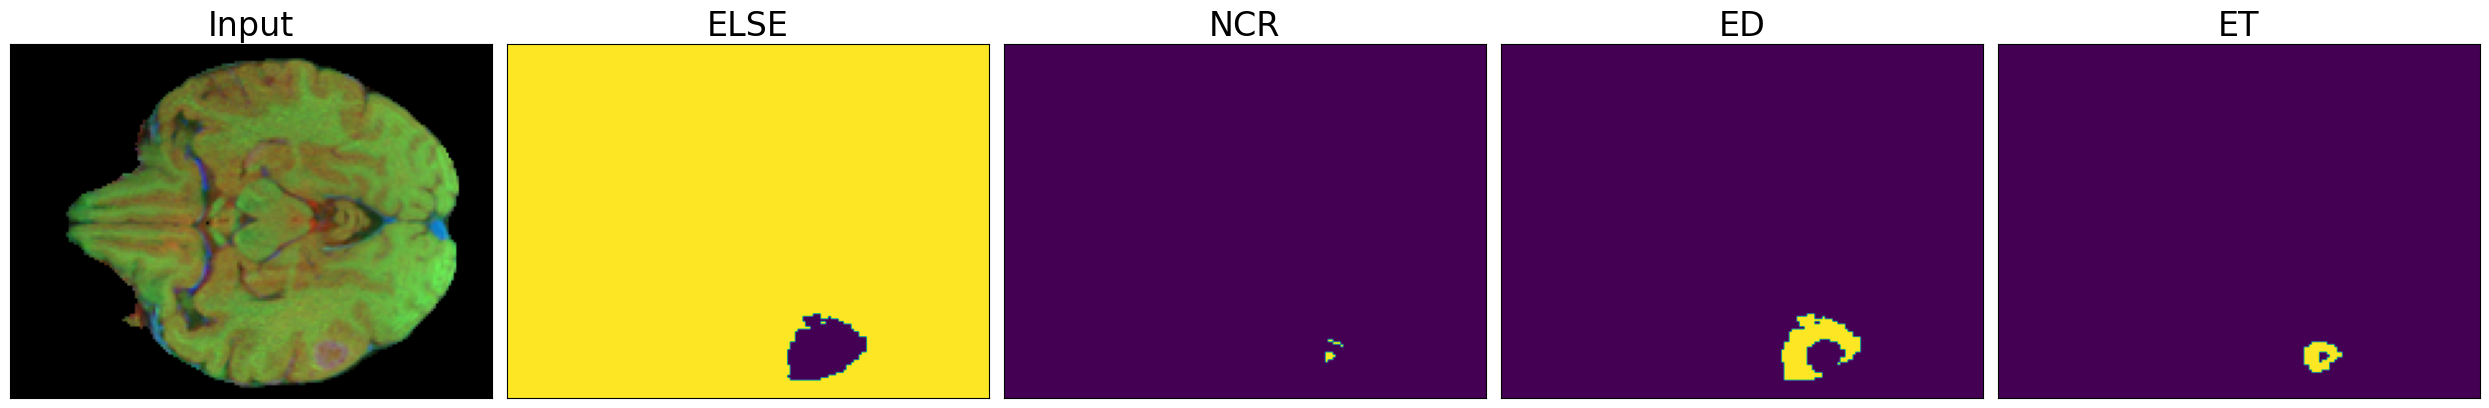

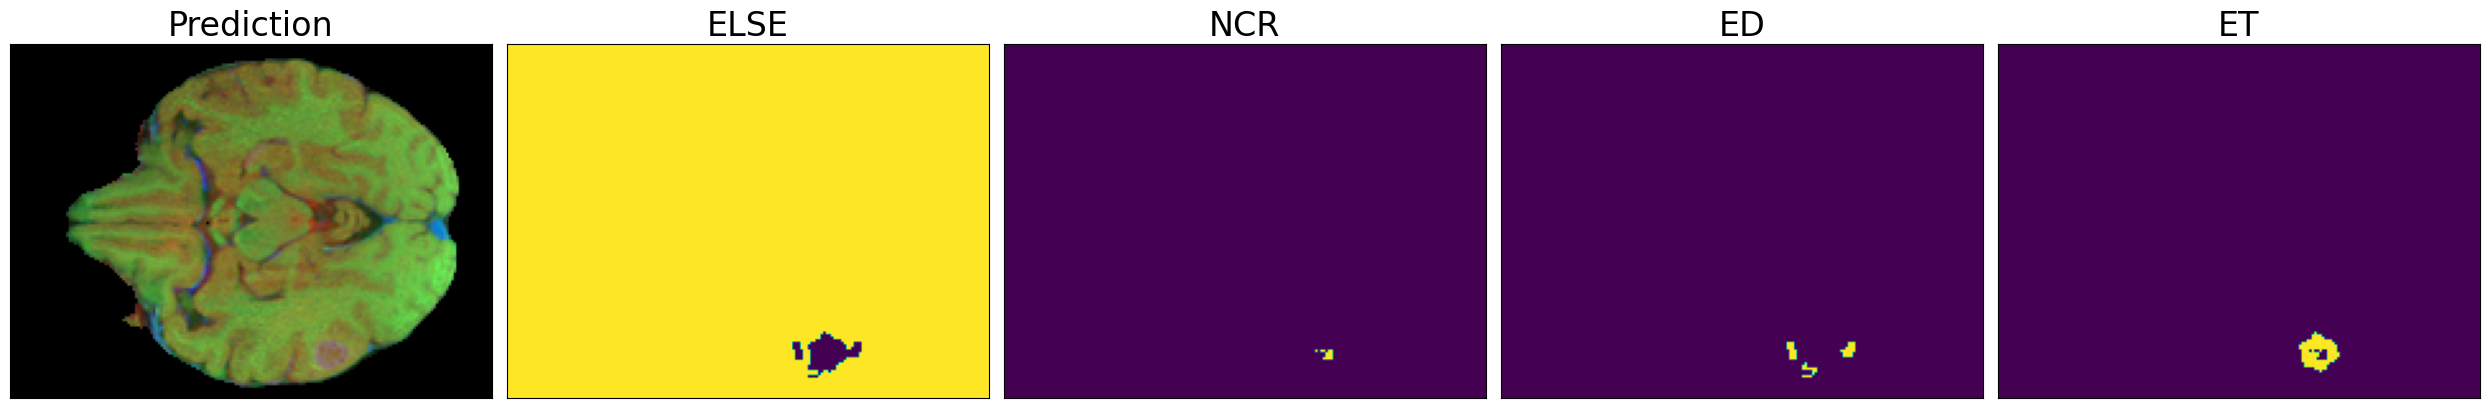

In [ ]:
# Choose an arbitrary slice since we cannot plot a 3d image
slice_idx = 62

# The parameters for the plot_mask_label functions are as follows:
# class_labels - the class labels for the particular slice
# pixel_values - the original input image
# mask_labels - either the input mask or the predicted mask

# Plot the ground truth segmentations
mf_utils.plot_mask_labels(class_labels=true_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_pred_3d[:, slice_idx, :, :],
             title= "Input")

# Plot the predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_true_3d[:, slice_idx, :, :],
             title= "Prediction")

